### Obtained Perplexity: -8.68, Coherence: 0.31, Best Number of Topics= 50

In [2]:
#Basic Libraries
import re
import numpy as np
import pandas as pd
from pprint import pprint
import sys
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
# spacy for lemmatization
import spacy
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

from topic_model_function import *

In [3]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [17]:
#Load Dataset
df=pd.read_csv('/Users/mahika.p/OneDrive - Cornell University/Anxiety/Topic_based_Gap_Analysis/Anxiety/Data/CSV/medium_text_2016.csv')
df = df.iloc[::5, :]
#getting rid of NaN
df=df.replace(np.nan, '', regex=True)
#Combining title and text
df["Post"] = df["title"] + df["text"]
#Now that we don't need Title or Text, we drop those columns before saving the file
df=df.drop(['title', 'text'], axis = 1)

In [18]:
df=df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [19]:
df.head()

,year,Post
0,2016,27 Minutes of Uber-Induced AnxietyAlternate ti...
5,2016,Anxiety.anx·i·e·ty/aNGˈzīədē/ noun. a feeling ...
10,2016,HelpDamn. There’s no way we’re going to make t...
15,2016,The Best Natural Treatments for AnxietyIf you ...
20,2016,“What do you mean women are overly self-critic...


In [20]:
# Convert to list
data=df.Post.values.tolist()
# Remove new line characters
data=[re.sub('\s+', ' ', sent) for sent in data]
# Remove distracting single quotes
data=[re.sub("\'", "", sent) for sent in data]

In [21]:
#Function to clean up text
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) 

In [22]:
#Clean up text
data_words=list(sent_to_words(data))
print(data_words[:1])

[['minutes', 'of', 'uber', 'induced', 'title', 'the', 'actual', 'thoughts', 'of', 'person', 'with', 'generalized', 'anxiety', 'disorder', 'trusting', 'total', 'stranger', 'to', 'drive', 'her', 'around', 'for', 'almost', 'half', 'an', 'hour', 'date', 'december', 'time', 'pm', 'pickup', 'location', 'san', 'francisco', 'international', 'airport', 'departures', 'terminal', 'door', 'destination', 'home', 'after', 'day', 'trip', 'to', 'ohio', 'visiting', 'my', 'family', 'wait', 'for', 'my', 'uber', 'driver', 'to', 'arrive', 'he', 'driving', 'black', 'prius', 'just', 'like', 'every', 'other', 'uber', 'driver', 'tonight', 'notice', 'for', 'the', 'first', 'time', 'that', 'the', 'phone', 'app', 'shows', 'the', 'license', 'plate', 'number', 'that', 'handy', 'manage', 'to', 'avoid', 'getting', 'into', 'the', 'wrong', 'car', 'the', 'driver', 'loads', 'my', 'suitcase', 'in', 'the', 'trunk', 'and', 'asks', 'me', 'which', 'route', 'usually', 'take', 'home', 've', 'never', 'been', 'asked', 'this', 'bef

In [23]:
# Build the bigram and trigram models
bigram=gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram=gensim.models.Phrases(bigram[data_words], threshold=100)

In [24]:
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod=gensim.models.phrases.Phraser(bigram)
trigram_mod=gensim.models.phrases.Phraser(trigram)

In [25]:
# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['minutes', 'of', 'uber', 'induced', 'title', 'the', 'actual', 'thoughts', 'of', 'person', 'with', 'generalized', 'anxiety', 'disorder', 'trusting', 'total', 'stranger', 'to', 'drive', 'her', 'around', 'for', 'almost', 'half', 'an', 'hour', 'date', 'december', 'time', 'pm', 'pickup', 'location', 'san', 'francisco', 'international', 'airport', 'departures', 'terminal', 'door', 'destination', 'home', 'after', 'day', 'trip', 'to', 'ohio', 'visiting', 'my', 'family', 'wait', 'for', 'my', 'uber', 'driver', 'to', 'arrive', 'he', 'driving', 'black', 'prius', 'just', 'like', 'every', 'other', 'uber', 'driver', 'tonight', 'notice', 'for', 'the', 'first', 'time', 'that', 'the', 'phone', 'app', 'shows', 'the', 'license', 'plate', 'number', 'that', 'handy', 'manage', 'to', 'avoid', 'getting', 'into', 'the', 'wrong', 'car', 'the', 'driver', 'loads', 'my', 'suitcase', 'in', 'the', 'trunk', 'and', 'asks', 'me', 'which', 'route', 'usually', 'take', 'home', 've', 'never', 'been', 'asked', 'this', 'befo

In [13]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]


In [14]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [34]:
# data_words_nostops = remove_stopwords(data_words)
# data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
# nlp = spacy.load("en_core_web_sm")

# # 1. Do lemmatization keeping only noun, adj, vb, adv
# data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# # 2. Create Dictionary needed for topic modelling
# id2word = corpora.Dictionary(data_lemmatized)

# # 3. Create Corpus
# texts = data_lemmatized

# # 4. Term Document Frequency and Create a bag of words
# bow_corpus = bow(dictionary=id2word, processed_docs=texts)

# # 5. Calculate low_tfidf_words
# # Keep only words with tfidf ranking <= x * len(dictionary)
# x = 0.2
# total_word_count, DictDocFreq = tf_df(bow_corpus, id2word)
# sorted_TFIDF = sort_tfidf(bow_corpus, total_word_count, DictDocFreq)
# low_tfidf_words = get_low_tfidf_words(x, id2word, sorted_TFIDF)

# # 6. Filter out least frequently used words
# no_below = 0.01
# keep_n = 10000
# dict_least_freq_filtered = filter_least_frequent(id2word, texts, 
#                                                  no_below, keep_n)

# # 7. Filter out most commonly used words (i.e. words with low TF-IDF score)
# dict_tfidf_filtered = filter_most_common(dict_least_freq_filtered, low_tfidf_words)

# # 8. Create the second bag of words - bow_corpus_TFIDFfiltered, 
# # created after least frequently and most commonly used words were filtered out.
# corpus = bow(dict_tfidf_filtered, texts)

# # View
# [[(dict_tfidf_filtered[id], freq) for id, freq in cp] for cp in corpus[:1]]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dict_tfidf_filtered,
                                           num_topics=50,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [36]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(22,
  '0.000*"tag" + 0.000*"swirl" + 0.000*"wednesday" + 0.000*"utterly" + '
  '0.000*"therefore" + 0.000*"taste" + 0.000*"presentation" + 0.000*"reserve" '
  '+ 0.000*"shirt" + 0.000*"toy"'),
 (34,
  '0.000*"tag" + 0.000*"swirl" + 0.000*"wednesday" + 0.000*"utterly" + '
  '0.000*"therefore" + 0.000*"taste" + 0.000*"presentation" + 0.000*"reserve" '
  '+ 0.000*"shirt" + 0.000*"toy"'),
 (12,
  '0.000*"tag" + 0.000*"swirl" + 0.000*"wednesday" + 0.000*"utterly" + '
  '0.000*"therefore" + 0.000*"taste" + 0.000*"presentation" + 0.000*"reserve" '
  '+ 0.000*"shirt" + 0.000*"toy"'),
 (18,
  '0.000*"tag" + 0.000*"swirl" + 0.000*"wednesday" + 0.000*"utterly" + '
  '0.000*"therefore" + 0.000*"taste" + 0.000*"presentation" + 0.000*"reserve" '
  '+ 0.000*"shirt" + 0.000*"toy"'),
 (7,
  '0.000*"sale" + 0.000*"analogy" + 0.000*"psychiatrist" + 0.000*"really" + '
  '0.000*"paranoia" + 0.000*"tag" + 0.000*"utterly" + 0.000*"therefore" + '
  '0.000*"taste" + 0.000*"conference"'),
 (15,
  '0.000*"air"

In [37]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -9.458688645798386


In [38]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dict_tfidf_filtered, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.43832190131121096


In [42]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df=pd.DataFrame()
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row=row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row=sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j==0:  # => dominant topic
                wp=ldamodel.show_topic(topic_num)
                topic_keywords=", ".join([word for word, prop in wp])
                sent_topics_df=sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
     # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [43]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,10.0,0.2885,"really, love, never, try, friend, much, still,...","[minute, uber, induce, title, actual, thought,..."
1,1,33.0,0.5047,"say, tell, look, ask, hospital, see, check, pe...","[anxiety, anx, ty, angˈziəde, noun, feel, worr..."
2,2,33.0,0.4992,"say, tell, look, ask, hospital, see, check, pe...","[helpdamn, way, go, make, deadline, working, c..."
3,3,48.0,0.4500,"need, say, many, find, year, good, experience,...","[good, natural, treatment, anxietyif, many, am..."
4,4,33.0,0.7249,"say, tell, look, ask, hospital, see, check, pe...","[mean, woman, overly, self, critical, recent, ..."


In [44]:
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,10.0,0.2885,"really, love, never, try, friend, much, still,...","[minute, uber, induce, title, actual, thought,..."
1,1,33.0,0.5047,"say, tell, look, ask, hospital, see, check, pe...","[anxiety, anx, ty, angˈziəde, noun, feel, worr..."
2,2,33.0,0.4992,"say, tell, look, ask, hospital, see, check, pe...","[helpdamn, way, go, make, deadline, working, c..."
3,3,48.0,0.4500,"need, say, many, find, year, good, experience,...","[good, natural, treatment, anxietyif, many, am..."
4,4,33.0,0.7249,"say, tell, look, ask, hospital, see, check, pe...","[mean, woman, overly, self, critical, recent, ..."
...,...,...,...,...,...
547,547,48.0,0.4451,"need, say, many, find, year, good, experience,...","[many, benefit, help, sleep, easy, toss, turn,..."
548,548,10.0,0.4868,"really, love, never, try, friend, much, still,...","[hate, mental, illnessaiight, walk, narrative,..."
549,549,3.0,0.3478,"disorder, treatment, stress, also, medication,...","[secret, weapon, treatment, anxiety, disordera..."
550,550,10.0,0.4288,"really, love, never, try, friend, much, still,...","[want, beyou, know, dream, suddenly, christmas..."


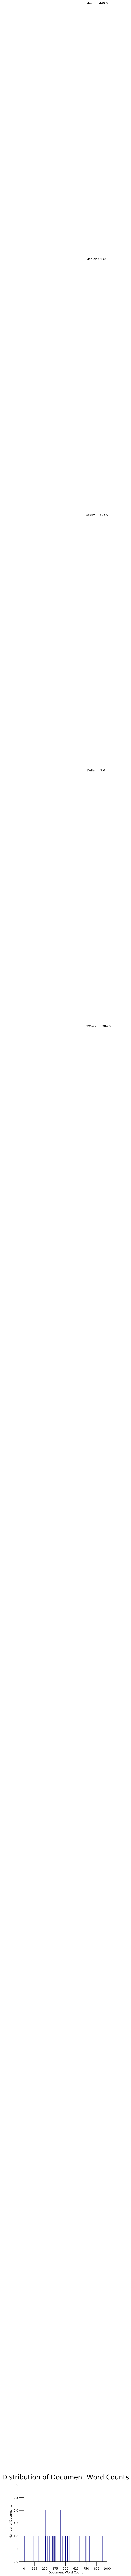

In [21]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(5,5), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

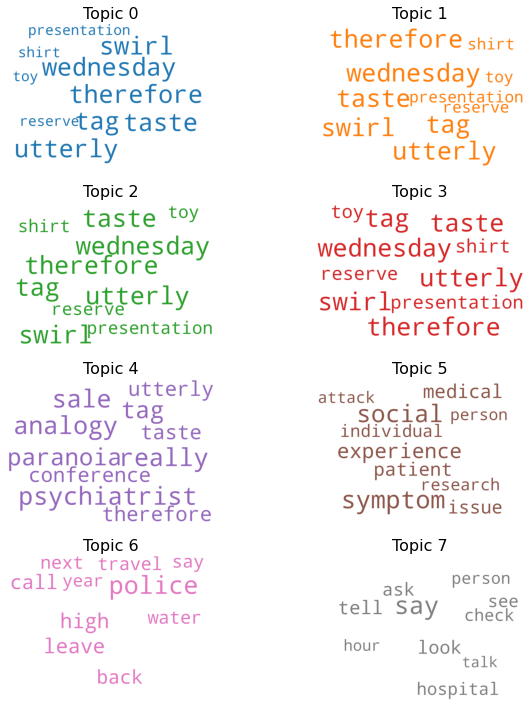

In [45]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(4, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [38]:
df_dominant_topic.to_csv("Medium2016.csv")

In [27]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(alpha='auto', corpus=corpus, num_topics=num_topics, 
                                                id2word=dictionary, random_state=100)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [28]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dict_tfidf_filtered, corpus=corpus, 
                                                        texts=data_lemmatized, start=2, limit=100, step=8)


[range(2, 100, 8)]
[0.3031300503461518, 0.3830418428673636, 0.38868820263020676, 0.36440972297763996, 0.36785035678891875, 0.37952292579078334, 0.386589686066583, 0.3753029114793491, 0.38393540432286277, 0.35495356312566867, 0.37021787202023304, 0.3617338075328349, 0.3501591269561518]


(10, 0.07991179252121178, 0.3830418428673636)

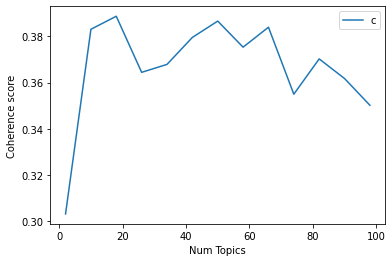

In [33]:
# Show graph
limit=100; start=2; step=8;
x = range(start, limit, step)
print(x)
print(coherence_values)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')

def differences(values, x):
    """
    Returns (optimal number of topics, largest jump, coherance value after jump)
    Params:
        values: list of coherance numbers, 
        x: num topics
    """
    max_diff = (0,0,0)
    for i in range(1,len(values)):
        if values[i]-values[i-1] > max_diff[1]:
            max_diff = (x[i], values[i]-values[i-1], values[i])
    return max_diff

differences(coherence_values, x)